# Mutliple multiplications, multiple layers - PCA

I'm going to focus now more on input data and activations as opposed to parameters.

In [1]:
import torch
from torch import nn
from torch.optim import Adam
from matplotlib import pyplot as plt
from matplotlib import cm
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np

from physics_mi.utils import set_all_seeds

In [2]:
seed = np.random.randint(1, 2**32 - 1)
# seed = 689334534
set_all_seeds(seed)
print(seed)

2193000570


## Model

Keeping this extremely simple

In [3]:
class LinearLayer(nn.Module):
    def __init__(self, in_feats, out_feats, use_act=True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.linear = nn.Linear(in_feats, out_feats)
        if use_act:
            self.act = nn.ReLU()
        self.use_act = use_act

    def forward(self, x):
        x = self.linear(x)
        if self.use_act:
            x = self.act(x)
        return x


class Net(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=16, output_dim=2, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(
            LinearLayer(input_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, output_dim, use_act=False),
        )

    def forward(self, x):
        return self.layers(x)

## Data

In [4]:
import torch

# Number of samples
n_samples = 10000

# Epsilon value
eps = 0.5


# Generate Y values
def generate_Y(n_samples):
    return torch.rand(n_samples)


# Generate X values based on Y
def generate_X(Y, eps):
    X = torch.empty(len(Y), 2)
    X[:, 0] = Y / (torch.rand(len(Y)) * (1 - eps) + eps)
    X[:, 1] = Y / X[:, 0]

    # Randomly swap x1 and x2
    mask = torch.rand(len(Y)) < 0.5
    swap_vals = X[:, 0][mask]
    X[:, 0][mask] = X[:, 1][mask]
    X[:, 1][mask] = swap_vals

    return X


# Initial generation
Y1 = generate_Y(n_samples)
X1 = generate_X(Y1, eps)

# Ensure they are statistically independent by generating new Y and X values
Y2 = generate_Y(n_samples)
X2 = generate_X(Y2, eps)

# Stack X1 and X2 to get the desired shape
X = torch.cat((X1, X2), dim=1)

# Stack Y1 and Y2 for the desired shape
Y = torch.stack((Y1, Y2), dim=1)

# Validate the relationship
assert torch.allclose(X[:, 0] * X[:, 1], Y[:, 0])
assert torch.allclose(X[:, 2] * X[:, 3], Y[:, 1])

# Print the shapes
print(X.shape, Y.shape)

torch.Size([10000, 4]) torch.Size([10000, 2])


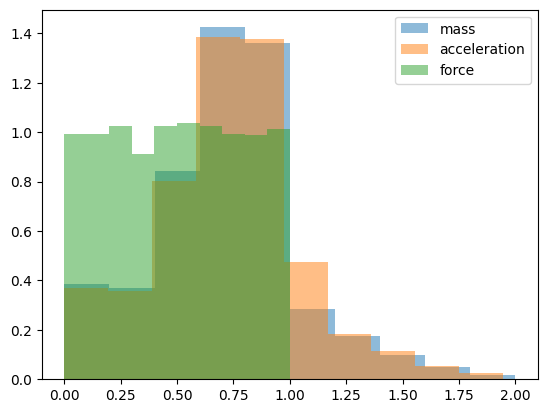

In [5]:
fig, ax = plt.subplots()

ax.hist(X[:, 0], alpha=0.5, density=True, label="mass")
ax.hist(X[:, 1], alpha=0.5, density=True, label="acceleration")
ax.hist(Y[:, 0], alpha=0.5, density=True, label="force")
ax.legend()

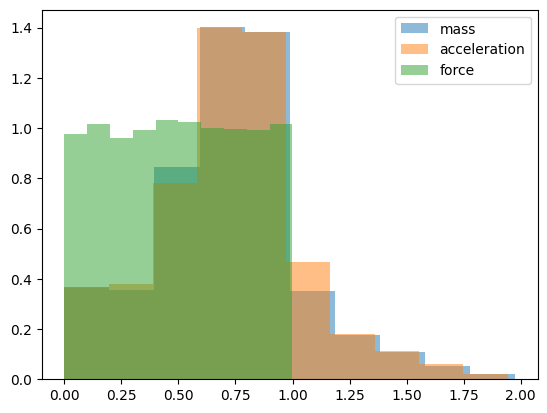

In [6]:
fig, ax = plt.subplots()

ax.hist(X[:, 2], alpha=0.5, density=True, label="mass")
ax.hist(X[:, 3], alpha=0.5, density=True, label="acceleration")
ax.hist(Y[:, 1], alpha=0.5, density=True, label="force")
ax.legend()

Ok, both now look identically distributed.

In [7]:
s_inds = np.random.permutation(range(X.shape[0]))  # shuffled indices

X_train = X[s_inds[:8000]]
Y_train = Y[s_inds[:8000]]
X_valid = X[s_inds[8000:]]
Y_valid = Y[s_inds[8000:]]

X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

(torch.Size([8000, 4]),
 torch.Size([8000, 2]),
 torch.Size([2000, 4]),
 torch.Size([2000, 2]))

## Training

I'll just do full gradient descent to keep things simple.

In [8]:
N = 4000  # number of epochs
hidden_dim = 16  # number of hidden units

model = Net(input_dim=4, hidden_dim=hidden_dim, output_dim=2)
loss_func = nn.MSELoss()
optimiser = Adam(model.parameters(), lr=1e-2)
log = []

for i in tqdm(range(N)):
    log_sample = {}

    # Training update
    model.train()
    model.zero_grad()
    Y_hat = model(X_train)
    loss = loss_func(Y_hat, Y_train)
    log_sample["train_loss"] = float(loss.detach())
    loss.backward()
    optimiser.step()

    # Validation set
    model.eval()
    Y_hat = model(X_valid)
    loss = loss_func(Y_hat, Y_valid)
    log_sample["valid_loss"] = float(loss.detach())

    log.append(log_sample)

df = pd.DataFrame(log)

  0%|          | 0/4000 [00:00<?, ?it/s]

## Results

In [9]:
from physics_mi.eval import *


# need to avoid flattening here because we have multiple outputs
def get_preds(model, X_valid, Y_valid):
    model.eval()

    with torch.inference_mode():
        out = model(X_valid)

    y_preds = out.numpy()
    y_targs = Y_valid.numpy()

    return y_preds, y_targs

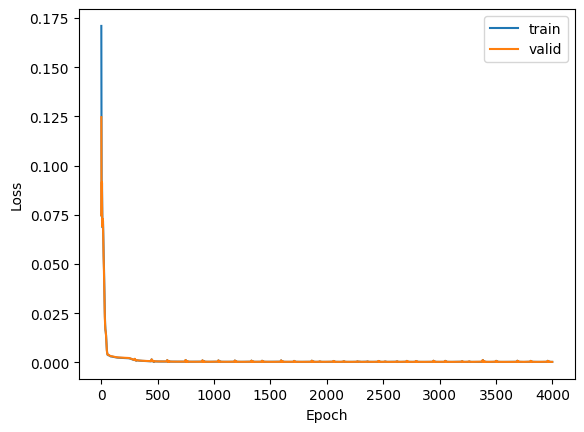

In [10]:
plot_loss(df["train_loss"], df["valid_loss"])

In [11]:
y_preds, y_targs = get_preds(model, X_valid, Y_valid)
y_preds.shape, y_targs.shape

((2000, 2), (2000, 2))

In [12]:
get_valid_loss(model, loss_func, X_valid, Y_valid)

tensor(0.0003)

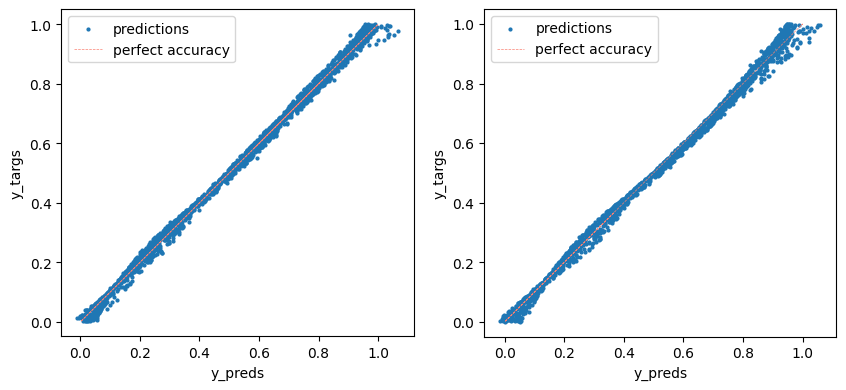

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

plot_results(y_preds[:, 0], y_targs[:, 0], ax=axes[0])
plot_results(y_preds[:, 1], y_targs[:, 1], ax=axes[1])

Both tasks seem to be doing well in parallel 👍

## Introspection

In [20]:
from physics_mi.analysis import capture_intermediate_outputs

In [35]:
def get_inputs(N=100, vary_task="A"):
    pairs = np.concatenate(np.stack(np.meshgrid(np.linspace(0, 1, N), np.linspace(0, 1, N))).T)
    pairs = torch.tensor(pairs, dtype=torch.float32)
    if vary_task == "A":
        inputs = torch.cat((pairs, torch.full((len(pairs), 2), 0.5)), dim=1)
    if vary_task == "B":
        inputs = torch.cat((torch.full((len(pairs), 2), 0.5), pairs), dim=1)
    return inputs

In [41]:
inputs = torch.cat((get_inputs(100, vary_task="A"), get_inputs(100, vary_task="B")))
inputs.shape

torch.Size([20000, 4])

In [43]:
ios = capture_intermediate_outputs(model, inputs)

In [46]:
acts = ios["layers.0.act"]
acts.shape

torch.Size([20000, 16])

In [50]:
def get_pcs(data):
    mean = torch.mean(data, 0)
    data_centered = data - mean

    # Step 2: Compute the SVD
    U, S, V = torch.svd(data_centered)

    # The columns of V are the principal components
    principal_components = V

    # Step 3: Compute variances
    variances = S.pow(2) / (data.size(0) - 1)

    return principal_components, variances

In [51]:
pcsA, vsA = get_pcs(acts[:10000])
pcsB, vsB = get_pcs(acts[10000:])

In [54]:
torch.dot(pcsA[-1], pcsB[-1])

tensor(-0.3353)

In [56]:
vsA, vsB

(tensor([1.7042e-01, 1.0793e-01, 5.7599e-03, 2.3499e-04, 2.3083e-07, 4.3424e-08,
         7.0251e-15, 8.0735e-16, 5.4410e-16, 5.0580e-16, 3.2699e-16, 3.0998e-16,
         2.2628e-16, 1.4859e-16, 2.2233e-32, 0.0000e+00]),
 tensor([1.8226e-01, 1.3903e-01, 8.1475e-03, 9.3504e-04, 1.9583e-05, 1.0012e-05,
         4.6525e-15, 7.1901e-16, 5.6182e-16, 4.0654e-16, 3.4206e-16, 1.4850e-16,
         1.4428e-16, 2.4057e-18, 6.8819e-32, 0.0000e+00]))

TBC